In [3]:
import imblearn

import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets, preprocessing
from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef, roc_curve, auc, make_scorer
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
import bisect
from immas import classification
from sklearn.utils import shuffle

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

# Loading of data and splitting in groups according to images

In [4]:
# Regions of the same image will stay in the same Pandas Dataframe in the end (dataset_df1 or dataset_df2)

# Load the dataset and groups by image filename
filename = "feature-tables/train-data_1527086478.csv" # no LBP
#filename = "feature-tables/train-data_1527093743.csv" # with LBP

dataset_df1, dataset_df2 = classification.load_features_data(filename)

# Conversion from pandas dataframe to numpy array
# Keeps all the features from the original csv file
Feature = dataset_df1.drop(['class_id','img_name'], axis=1)
Target  = dataset_df1['class_id']
dataset01_data = Feature.as_matrix()
dataset01_labels = Target.as_matrix()

Feature = dataset_df2.drop(['class_id','img_name'], axis=1)
Target  = dataset_df2['class_id']
dataset02_data = Feature.as_matrix()
dataset02_labels = Target.as_matrix()

# Shuflles the datasets and creates one variable with labels for all the samples
dataset01_data, dataset01_labels = shuffle(dataset01_data, dataset01_labels, random_state=None)
dataset02_data, dataset02_labels = shuffle(dataset02_data, dataset02_labels, random_state=None)
all_data_raw = np.vstack((dataset01_data, dataset02_data))
all_labels_raw = np.concatenate((dataset01_labels, dataset02_labels),axis=0)

# Data standardization for each dataset (two methods)
dataset01_data = preprocessing.StandardScaler().fit_transform(dataset01_data)
dataset02_data = preprocessing.StandardScaler().fit_transform(dataset02_data)
all_data_raw = preprocessing.StandardScaler().fit_transform(all_data_raw)
#dataset01_data = preprocessing.robust_scale(dataset01_data)fit_transform
#dataset02_data = preprocessing.robust_scale(dataset02_data)

# Concatenates data and labels of dataset01 into one array
dataset01 = np.zeros((dataset01_data.shape[0],dataset01_data.shape[1]+1));
dataset01[:,:-1] = dataset01_data
dataset01[:,-1] = dataset01_labels

# Concatenates data and labels of dataset02 into one array
dataset02 = np.zeros((dataset02_data.shape[0],dataset02_data.shape[1]+1));
dataset02[:,:-1] = dataset02_data
dataset02[:,-1] = dataset02_labels

dataset_df1.head()

Number of images in the dataset 01: 205
Number of images in the dataset 02: 205
Number of regions in dataset 01: 3146
Number of regions in dataset 02: 3230


,perimeter,area,circularity,ac,shape_factor,mean NRL,SD NRL,Ratio SD NRL and mean RL,entropy NRL,NCPS,...,contrast,uniformity,homogeneity,energy,dissimilarity,gradient mean,gradient SD,gradient skewness,class_id,img_name
10,1355.906635,31143.0,4.697743,6629.353592,59.033581,0.638413,0.239229,0.002594,5.377388,0.001900,...,381.321649,0.196445,0.472807,0.443221,11.889427,28557.491525,31026.408351,0.273095,-1.0,22614074_6bd24a0a42c19ce1_MG_R_CC_ANON
11,1111.379723,23984.5,4.098117,5852.565252,51.498463,0.577498,0.217161,0.002465,5.133397,0.002371,...,316.643025,0.291789,0.564016,0.540175,9.845182,29874.672131,31583.123298,0.186072,-1.0,22614074_6bd24a0a42c19ce1_MG_R_CC_ANON
12,833.480229,22346.0,2.473893,9032.726247,31.087859,0.609551,0.155021,0.001868,5.109293,0.004716,...,397.804738,0.176235,0.449262,0.419804,12.443638,18975.491228,28104.567812,1.003877,-1.0,22614074_6bd24a0a42c19ce1_MG_R_CC_ANON
13,1759.237588,21544.5,11.431486,1884.663032,143.652296,0.508991,0.272860,0.001847,4.920636,0.004877,...,373.406840,0.213132,0.491397,0.461662,11.561044,41183.209877,30428.064293,-0.563340,-1.0,22614074_6bd24a0a42c19ce1_MG_R_CC_ANON
14,1193.237588,16895.5,6.706145,2519.405715,84.271903,0.503876,0.267287,0.002893,4.964000,0.008760,...,188.879422,0.529220,0.742093,0.727475,5.864291,35953.047904,31488.274318,-0.204364,-1.0,22614074_6bd24a0a42c19ce1_MG_R_CC_ANON


# Data Augmentation with over sampling

In [5]:
# Parameters for features without LBP
oversampling_kernel = SMOTETomek(random_state=42,smote = SMOTE(random_state=0, k_neighbors=10, m_neighbors=5, kind='svm'))

dataset01_data_resampled, dataset01_labels_resampled = oversampling_kernel.fit_sample(dataset01_data, dataset01_labels)
dataset02_data_resampled, dataset02_labels_resampled = oversampling_kernel.fit_sample(dataset02_data, dataset02_labels)
all_data = np.vstack((dataset01_data_resampled, dataset02_data_resampled))
all_labels = np.concatenate((dataset01_labels_resampled, dataset02_labels_resampled),axis=0)

print(f"Data set 1 resampled {len(dataset01_labels_resampled)}")
print(f"Data set 2 resampled {len(dataset02_labels_resampled)}")
print(f"Number of masses, data set 1 {sum(dataset01_labels_resampled > 0)}")
print(f"Number of masses, data set 2 {sum(dataset02_labels_resampled > 0)}")

Data set 1 resampled 6173
Data set 2 resampled 6350
Number of masses, data set 1 3086
Number of masses, data set 2 3175


# Grid Search

In [15]:
# Fit and tune the algorithm
# try without oob-score
clf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', oob_score=True)

parameters = {'n_estimators': [35, 75, 101, 301, 501, 1001],
              'max_features': ['log2', 'sqrt'],
              'max_depth': [5, 10, 20],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
             }
# Run the grid search
grid_obj = GridSearchCV(clf,
                        param_grid=parameters,
                        scoring='roc_auc',
                        refit=True,
                        n_jobs=2,
                        pre_dispatch='2*n_jobs',
                        cv=2,
                        verbose=2,
                        return_train_score=False)

grid_obj = grid_obj.fit(all_data, all_labels)

# # Set the clf to the best combination of parameters
#clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
#clf.fit(x_train, y_train)

grid_obj.fit(all_data, all_labels)
print(grid_obj.best_score_, grid_obj.best_params_)

Fitting 2 folds for each of 324 candidates, totalling 648 fits
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=35 
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=35 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=35, total=   0.6s
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=75 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=35, total=   0.6s
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=75 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=75, total=   1.3s
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=101 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=75, total=   1.4s
[CV] max_depth=5, max

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.4min


[CV]  max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=35, total=   0.7s
[CV] max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=75 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=75, total=   1.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=101 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=75, total=   1.0s
[CV] max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=101 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=101, total=   1.4s
[CV] max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=301 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=101, total=   1.3s
[CV] max_depth=5, max_features=log2, min_samples_leaf=2, min_samp

[CV]  max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=101, total=   1.5s
[CV] max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=301 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=301, total=   4.0s
[CV]  max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=301, total=   4.0s
[CV] max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=501 
[CV] max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=501 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=501, total=   6.2s
[CV] max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1001 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=501, total=   6.2s
[CV] max_depth=5, max_features=log2, min_samples_leaf=4, min

[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1001 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=501, total=   7.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1001 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1001, total=  13.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1001, total=  13.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35, total=   0.8s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=

[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=75 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=35, total=   0.5s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=75 


[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  6.0min


[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=75, total=   1.0s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=101 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=75, total=   1.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=101 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=101, total=   1.3s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=301 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=101, total=   1.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=301 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=301, total=   4.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_sa

[CV] max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=301 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=301, total=   4.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=501 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=301, total=   4.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=501 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=501, total=   6.5s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1001 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=501, total=   6.4s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1001 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_spli

[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=501, total=   9.1s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1001 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1001, total=  17.8s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, total=   0.8s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1001, total=  18.4s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, total=   0.8s
[CV] max_depth=10, max_features=log2, min_samples

[CV] max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=75 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1001, total=  18.9s
[CV] max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=75 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=75, total=   1.3s
[CV] max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=101 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=75, total=   1.5s
[CV] max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=101 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=101, total=   1.9s
[CV] max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=301 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=2, min

[CV]  max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=101, total=   1.8s
[CV] max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=301 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=101, total=   1.8s
[CV] max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=301 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=301, total=   5.3s
[CV] max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=501 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=301, total=   5.5s
[CV] max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=501 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=501, total=   9.0s
[CV] max_depth=10, max_features=log2, min_s

[CV] max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=501 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=501, total=   9.1s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1001 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=501, total=   9.3s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1001 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1001, total=  18.4s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=35 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1001, total=  18.7s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=35 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2,

[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed: 15.8min


[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=35, total=   0.6s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=75 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=75, total=   1.4s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=101 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=75, total=   1.6s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=101 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=101, total=   1.8s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=301 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=101, total=   1.9s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2

[CV] max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=301 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=101, total=   1.9s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=301 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=301, total=   5.3s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=501 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=301, total=   5.6s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=501 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=501, total=   9.1s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1001 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=4, min_sam

[CV]  max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=501, total=  11.1s
[CV] max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1001 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=501, total=  11.1s
[CV] max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1001 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1001, total=  22.1s
[CV] max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35, total=   1.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1001, total=  22.9s
[CV] max_depth=20, max_features=log2, min_samples_l

[CV] max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=35 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1001, total=  22.2s
[CV] max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=75 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=35, total=   1.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=75 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=75, total=   1.5s
[CV] max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=101 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=75, total=   1.6s
[CV] max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=101 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_s

[CV]  max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=75, total=   1.5s
[CV] max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=101 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=101, total=   2.2s
[CV] max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=301 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=101, total=   2.1s
[CV] max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=301 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=301, total=   6.5s
[CV] max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=501 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=301, total=   6.6s
[CV] max_depth=20, max_features=log2, min_samples_lea

[CV] max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=501 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=301, total=   6.6s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=501 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=501, total=  10.9s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1001 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=501, total=  11.2s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1001 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1001, total=  21.8s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=1, min_s

[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1001, total=  21.3s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=35 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=35, total=   0.9s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=35 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1001, total=  22.1s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=75 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=35, total=   1.0s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=75 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=75, total=   1.7s
[CV] max_depth=20, max_features=sqrt, min_samples_

[CV] max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=75 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=75, total=   1.6s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=101 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=75, total=   1.6s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=101 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=101, total=   2.2s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=301 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=101, total=   2.3s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=301 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, mi

[Parallel(n_jobs=2)]: Done 644 tasks      | elapsed: 32.1min


[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=501, total=   9.9s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1001 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=501, total=  10.3s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1001 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1001, total=  19.9s
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1001, total=  20.3s


[Parallel(n_jobs=2)]: Done 648 out of 648 | elapsed: 32.6min finished


Fitting 2 folds for each of 324 candidates, totalling 648 fits
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=35 
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=35 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=35, total=   0.6s
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=75 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=35, total=   0.6s
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=75 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=75, total=   0.9s
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=101 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=75, total=   1.1s
[CV] max_depth=5, max

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.4min


[CV]  max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=35, total=   0.6s
[CV] max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=75 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=75, total=   0.9s
[CV] max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=101 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=75, total=   1.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=101 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=101, total=   1.3s
[CV] max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=301 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=101, total=   1.3s
[CV] max_depth=5, max_features=log2, min_samples_leaf=2, min_samp

[CV]  max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=101, total=   1.4s
[CV] max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=301 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=301, total=   4.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=501 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=301, total=   4.2s
[CV] max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=501 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=501, total=   6.9s
[CV] max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1001 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=501, total=   7.0s
[CV] max_depth=5, max_features=log2, min_samples_leaf=4, min

[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1001 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=501, total=   6.9s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1001 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1001, total=  13.0s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35, total=   0.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1001, total=  13.4s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=

[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=75 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=35, total=   0.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=75 


[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  6.0min


[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=75, total=   1.0s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=101 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=75, total=   1.0s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=101 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=101, total=   1.3s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=301 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=101, total=   1.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=301 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=301, total=   4.0s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_sa

[CV] max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=301 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=301, total=   3.8s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=501 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=301, total=   3.8s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=501 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=501, total=   6.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1001 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=501, total=   6.9s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1001 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_spli

[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=501, total=   9.4s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1001 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1001, total=  18.5s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, total=   0.7s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, total=   0.8s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1001, total=  19.0s
[CV] max_depth=10, max_features=log2, min_samples

[CV] max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=75 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=35, total=   1.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=75 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=75, total=   1.2s
[CV] max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=101 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=75, total=   1.5s
[CV] max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=101 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=101, total=   1.9s
[CV] max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=301 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=2, min_

[CV]  max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=101, total=   1.8s
[CV] max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=301 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=101, total=   1.7s
[CV] max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=301 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=301, total=   5.5s
[CV] max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=501 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=301, total=   5.6s
[CV] max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=501 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=501, total=   9.3s
[CV] max_depth=10, max_features=log2, min_s

[CV] max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=501 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=501, total=   9.0s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1001 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=501, total=   9.4s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1001 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1001, total=  18.0s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=35 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=35, total=   0.6s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=35 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, mi

[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed: 15.9min


[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=75, total=   1.5s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=101 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=75, total=   1.4s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=101 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=101, total=   1.9s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=301 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=101, total=   1.9s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=301 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=301, total=   5.3s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf

[CV] max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=301 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=301, total=   5.5s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=501 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=301, total=   5.7s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=501 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=501, total=   9.0s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1001 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=501, total=   9.1s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1001 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=4, min_sa

[CV]  max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=501, total=  11.3s
[CV] max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1001 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1001, total=  21.3s
[CV] max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35, total=   0.9s
[CV] max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35, total=   0.8s
[CV] max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1001, total=  22.7s
[CV] max_depth=20, max_features=log2, min_samples_leaf

[CV] max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=75 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=35, total=   1.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=75 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=75, total=   1.6s
[CV] max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=101 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=75, total=   1.7s
[CV] max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=101 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=101, total=   2.3s
[CV] max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=301 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_s

[CV]  max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=101, total=   2.3s
[CV] max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=301 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=101, total=   2.3s
[CV] max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=301 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=301, total=   7.2s
[CV] max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=501 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=301, total=   7.3s
[CV] max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=501 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=501, total=  10.6s
[CV] max_depth=20, max_features=log2, min_samples_le

[CV] max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=501 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=501, total=  14.6s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1001 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=501, total=  14.9s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1001 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1001, total=  25.8s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35, total=   1.0s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=1, min_s

[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=35, total=   0.9s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=35 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1001, total=  24.7s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=75 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=35, total=   1.1s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=75 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=75, total=   1.7s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=101 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=75, total=   1.8s
[CV] max_depth=20, max_features=sqrt, min_samples_

[CV] max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=101 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=75, total=   3.2s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=101 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=101, total=   3.9s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=301 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=101, total=   3.8s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=301 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=301, total=  10.5s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=501 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, 

[Parallel(n_jobs=2)]: Done 644 tasks      | elapsed: 34.2min


[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=501, total=  15.4s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1001 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=501, total=  16.0s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1001 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1001, total=  33.5s
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1001, total=  34.7s


[Parallel(n_jobs=2)]: Done 648 out of 648 | elapsed: 35.1min finished


0.9656767595606418 {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75}


In [16]:
print(grid_obj.best_score_, grid_obj.best_params_)

0.9656767595606418 {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75}


# Augmented vs original data

## Classifiers with original parameters

In [6]:
# 85% of masses detected, 85% accuracy, f1_score=20%, mathew_coef=25%
# Parameter selection by me, fit to the train data set firts

# dataset01_data, dataset01_labels
# dataset02_data, dataset02_labels
clf_aia_01 = RandomForestClassifier(n_estimators=1000, #500
                             max_features='sqrt',
                             min_samples_leaf=50,
                             class_weight='balanced',
                             oob_score=True)

clf_aia_01.fit(dataset01_data, dataset01_labels)

# Now fit to the test data set, classifier the same
clf_aia_02 = RandomForestClassifier(n_estimators=1000,
                             max_features='sqrt',
                             min_samples_leaf=50,
                             class_weight='balanced',
                             oob_score=True)

clf_aia_02.fit(dataset02_data, dataset02_labels)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [7]:
prob_aia_01 = clf_aia_01.predict_proba(dataset02_data)
pred_aia_01 = clf_aia_01.predict(dataset02_data)

prob_aia_02 = clf_aia_02.predict_proba(dataset01_data)
pred_aia_02 = clf_aia_02.predict(dataset01_data)

prob_aia = np.vstack((prob_aia_01, prob_aia_02))
pred_aia = np.concatenate((pred_aia_01, pred_aia_02), axis=0)

labels = np.concatenate((dataset02_labels, dataset01_labels))

# Optimal classifier

In [8]:
# dataset01_data_resampled, dataset01_labels_resampled
# dataset02_data_resampled, dataset02_labels_resampled

# optimal parameters
#{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75}
clf_rs_01 = RandomForestClassifier(n_estimators=75,
                             max_features='sqrt',
                             min_samples_leaf=1,
                             min_samples_split=2,
                             max_depth=5,
                             class_weight='balanced',
                             oob_score=True)

# clf_rs_01 = RandomForestClassifier(n_estimators=1000, #500
#                              max_features='sqrt',
#                              min_samples_leaf=50,
#                              class_weight='balanced',
#                              oob_score=True)

clf_rs_01.fit(dataset01_data_resampled, dataset01_labels_resampled)

# Now fit to the test data set, classifier the same
clf_rs_02 = RandomForestClassifier(n_estimators=75,
                             max_features='sqrt',
                             min_samples_leaf=1,
                             min_samples_split=2,
                             max_depth=5,
                             class_weight='balanced',
                             oob_score=True)

# clf_rs_02 = RandomForestClassifier(n_estimators=1000, #500
#                              max_features='sqrt',
#                              min_samples_leaf=50,
#                              class_weight='balanced',
#                              oob_score=True)

clf_rs_02.fit(dataset02_data_resampled, dataset02_labels_resampled)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=75, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [9]:
prob_rs_01 = clf_rs_01.predict_proba(dataset02_data)
pred_rs_01 = clf_rs_01.predict(dataset02_data)

prob_rs_02 = clf_rs_02.predict_proba(dataset01_data)
pred_rs_02 = clf_rs_02.predict(dataset01_data)

prob_rs = np.vstack((prob_rs_01, prob_rs_02))
pred_rs = np.concatenate((pred_rs_01, pred_rs_02), axis=0)

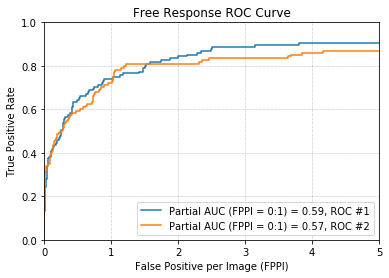

In [10]:
# Counts to adjust the TPR and to create the False Positive per Image
_, counts = np.unique(labels, return_counts=True)
num_img = 410
num_pos_img = 115
pos_reg = counts[1]
neg_reg = counts[0]
neg_reg_per_img = neg_reg / num_img
pos_reg_per_pimg = pos_reg / num_pos_img

# all_labels - for reshaped data
classification.get_roc((labels, labels), (prob_aia, prob_rs), neg_reg_per_img, pos_reg_per_pimg)